In [17]:
#################### #
# Attach packages ----
#################### #

library(tidyverse)
library(readxl)
library(writexl)
library(skimr)

In [18]:
#################### #
# Import more data sets ----
#################### #

houses_raw     <- read_excel("input/houses.xlsx")
geo_raw        <- read_excel("input/geo.xlsx")
zip_raw        <- read_excel("input/zip.xlsx")
income_raw     <- read_excel("input/income.xlsx")
attributes_raw <- read_excel("input/attributes.xlsx")

In [19]:
#################### #
# Select relevant variables ----
#################### #

geo <- geo_raw %>% 
  select(id, kommune_no, kommune_name, fylke_no, fylke_name)

income <- income_raw %>% 
  select(zip_no      = postnr,
         avg_income  = gjsnitt_inntekt,
         avg_fortune = gjsnitt_formue)

zip        <- zip_raw
attributes <- attributes_raw

In [20]:
#################### #
# Merge data ----
#################### #

# Important to join zip before income
houses <- houses_raw %>% 
  left_join(geo,        by = "id") %>%
  left_join(zip,        by = "id") %>% 
  left_join(income,     by = "zip_no") %>%
  left_join(attributes, by = "id")

In [21]:
head(houses,3)

id,sqm,price,debt,expense,lat,lng,kommune_no,kommune_name,fylke_no,fylke_name,zip_no,zip_name,avg_income,avg_fortune,sqm_use,built,floor
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10001,152,9800000,NA,NA,59.95475,10.76841,0301,Oslo,0300,Oslo,0484,Oslo,428890,755524,190,1959,1
10002,66,3100000,175086,5147,59.94381,10.81159,0301,Oslo,0300,Oslo,0590,Oslo,421739,867066,66,1954,2
10003,189,8400000,NA,0,59.98290,11.01450,0231,Skedsmo,0200,Akershus,2007,Kjeller,356058,645496,234,1987,3


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 118 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


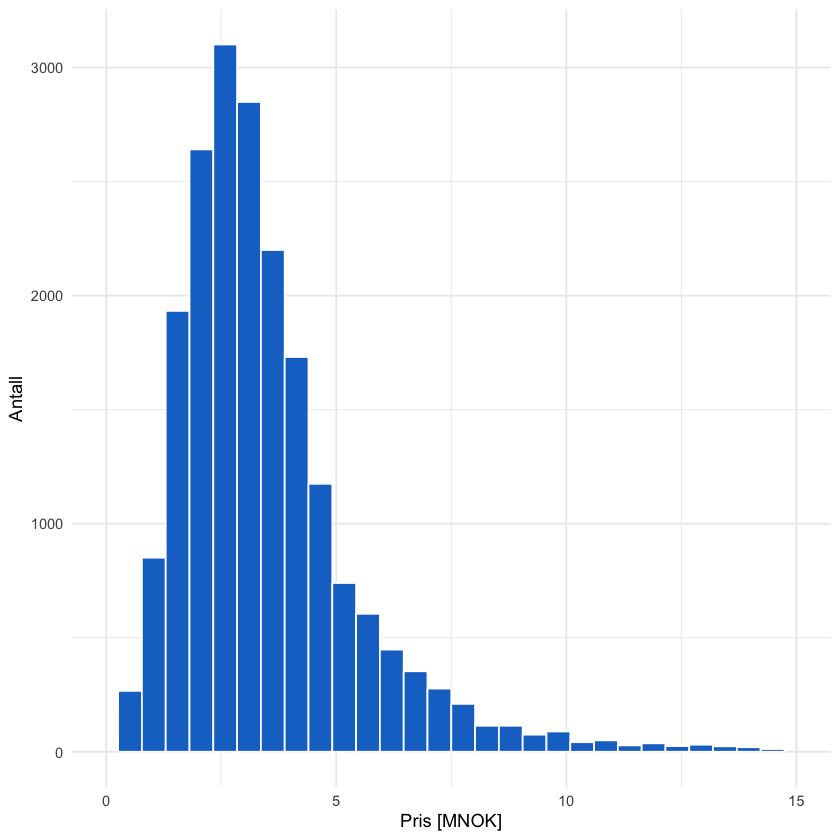

In [10]:
#####################################
# Prep and plot
#####################################

houses_output <- houses %>% 
  mutate(debt    = ifelse(is.na(debt), 0, debt),
         expense = ifelse(is.na(expense), 0, expense),
         tot_price         = price + debt, 
         tot_price_per_sqm = tot_price/sqm) %>% 
  drop_na()

houses_output %>% 
  ggplot(aes(x = tot_price/1000000)) +
  geom_histogram(fill = "dodgerblue3", color = "white") +
  labs(x = "Pris [MNOK]",
       y = "Antall") +
  xlim(0, 15) +
  theme_minimal()


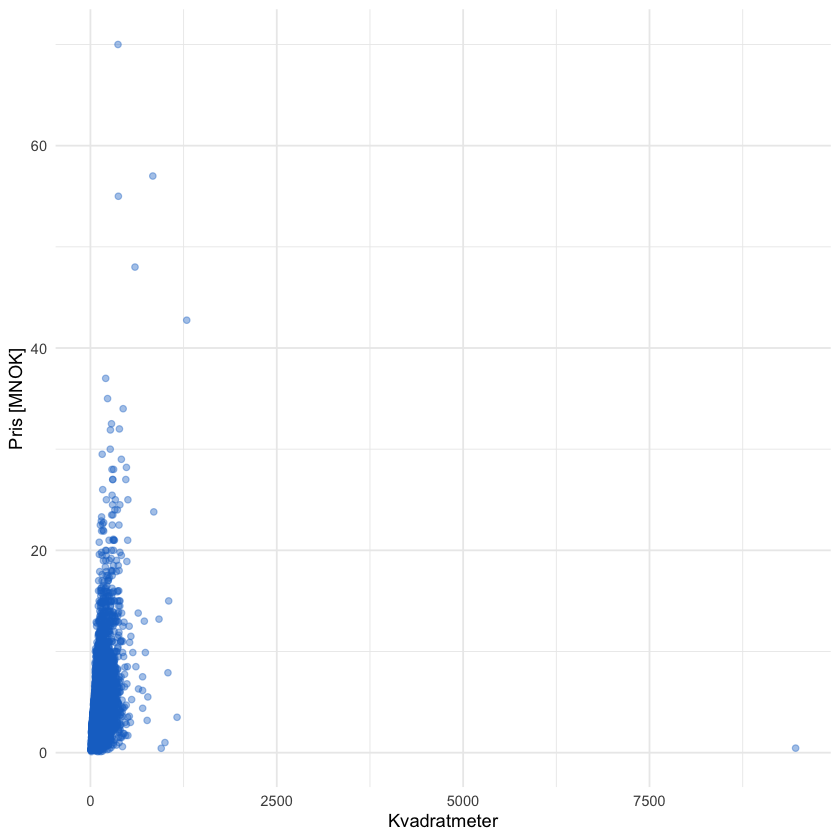

In [11]:
houses_output %>% 
  ggplot(aes(x = sqm, y = tot_price/1000000)) +
  geom_point(color = "dodgerblue3", alpha = 0.4) +
  labs(x = "Kvadratmeter",
       y = "Pris [MNOK]") +
  theme_minimal()

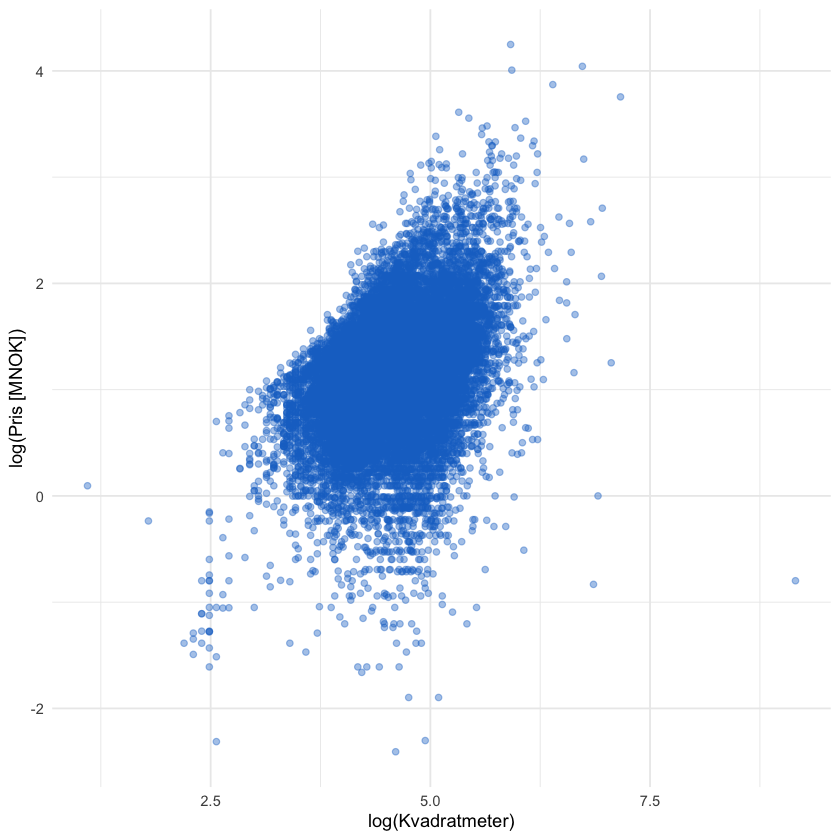

In [12]:
houses_output %>% 
  ggplot(aes(x = log(sqm), y = log(tot_price/1000000))) +
  geom_point(color = "dodgerblue3", alpha = 0.4) +
  labs(x = "log(Kvadratmeter)",
       y = "log(Pris [MNOK])") +
  theme_minimal()

In [13]:
##################################### #
# Create feature ----
##################################### #

# Two suggestions for finding number of houses nearby

# Suggestion 1: Number of houses within zip number
houses_within_zip <- houses_output %>% 
  count(zip_no, name = "n_houses_per_zip")

houses_output_zip <- houses_output %>% 
  left_join(houses_within_zip, by = "zip_no")

# Suggestion 2: Number of houses within 1500 meter
library(sf)

houses_sf <- houses_output %>% 
  st_as_sf(coords = c("lng", "lat"),
           crs    = 4326)
  
houses_within_radius <- houses_sf %>% 
  st_transform(25833) %>% 
  st_buffer(1500) %>% 
  st_transform(4326) %>% 
  st_intersection(houses_sf) %>% 
  st_set_geometry(NULL) %>% 
  count(id, name = "n_houses_nearby")

houses_output_nearby <- houses_output %>% 
  left_join(houses_within_radius, by = "id")



although coordinates are longitude/latitude, st_intersection assumes that they are planar

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


In [15]:
head(houses_output_zip)
head(houses_output_nearby)

id,sqm,price,debt,expense,lat,lng,kommune_no,kommune_name,fylke_no,⋯,zip_no,zip_name,avg_income,avg_fortune,sqm_use,built,floor,tot_price,tot_price_per_sqm,n_houses_per_zip
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
10001,152,9800000,0,0,59.95475,10.76841,0301,Oslo,0300,⋯,0484,Oslo,428890,755524,190,1959,1,9800000,64473.68,27
10002,66,3100000,175086,5147,59.94381,10.81159,0301,Oslo,0300,⋯,0590,Oslo,421739,867066,66,1954,2,3275086,49622.52,17
10003,189,8400000,0,0,59.98290,11.01450,0231,Skedsmo,0200,⋯,2007,Kjeller,356058,645496,234,1987,3,8400000,44444.44,30
10004,172,7250000,0,0,59.82327,10.80543,0217,Oppegård,0200,⋯,1410,Kolbotn,460748,1258491,187,1977,1,7250000,42151.16,26
10005,30,2200000,110000,2303,59.95219,10.91692,0301,Oslo,0300,⋯,0977,Oslo,197270,221625,30,1969,5,2310000,77000.00,3
10006,85,6400000,0,3780,59.91669,10.78984,0301,Oslo,0300,⋯,0661,Oslo,338756,532665,88,2017,6,6400000,75294.12,37


id,sqm,price,debt,expense,lat,lng,kommune_no,kommune_name,fylke_no,⋯,zip_no,zip_name,avg_income,avg_fortune,sqm_use,built,floor,tot_price,tot_price_per_sqm,n_houses_nearby
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
10001,152,9800000,0,0,59.95475,10.76841,0301,Oslo,0300,⋯,0484,Oslo,428890,755524,190,1959,1,9800000,64473.68,110
10002,66,3100000,175086,5147,59.94381,10.81159,0301,Oslo,0300,⋯,0590,Oslo,421739,867066,66,1954,2,3275086,49622.52,101
10003,189,8400000,0,0,59.98290,11.01450,0231,Skedsmo,0200,⋯,2007,Kjeller,356058,645496,234,1987,3,8400000,44444.44,24
10004,172,7250000,0,0,59.82327,10.80543,0217,Oppegård,0200,⋯,1410,Kolbotn,460748,1258491,187,1977,1,7250000,42151.16,60
10005,30,2200000,110000,2303,59.95219,10.91692,0301,Oslo,0300,⋯,0977,Oslo,197270,221625,30,1969,5,2310000,77000.00,63
10006,85,6400000,0,3780,59.91669,10.78984,0301,Oslo,0300,⋯,0661,Oslo,338756,532665,88,2017,6,6400000,75294.12,343


In [16]:
#################### #
# Excerise 5 - Write data to excel ----
#################### #

write_xlsx(houses_output_nearby, "temp/houses.xlsx")